In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import sys

import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from ipywidgets import interact, fixed

# Data config
DATA_DIR = "/root/autodl-tmp/COMP9417GroupProject/Data/"
BUFFER = 64
Z_START = 25
Z_DIM = 16
FIXED_HEIGHT = 4096

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
LEARNING_RATE = 1e-4


print("Device: ", DEVICE)
print("Python Version: ", sys.version)
print("PyTorch Version: ", torch.__version__)

"""
This code is written by Zongyuan LANG, z5319088
I was inspired in part by the winners of this Vesuvius Challenge. 
https://www.kaggle.com/code/fchollet/keras-starter-kit-unet-train-on-full-dataset
Note that the original author uses the tensorflow framework, while I use the pytorch framework. And all code is reimplemented and debugged.

For attention U-net, I partly refer to the following code from github:
https://github.com/sfczekalski/attention_unet

"""

Device:  cuda
Python Version:  3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
PyTorch Version:  2.0.0+cu118


/root/miniconda3/lib/python3.8/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


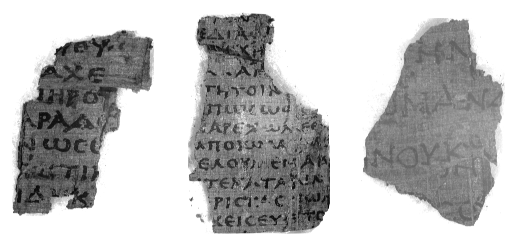

<Figure size 2000x1000 with 0 Axes>

In [17]:
for i in range(1,4):
    plt.subplot(1, 3, i)
    plt.imshow(Image.open(DATA_DIR + "train/" + str(i) + "/ir.png"), cmap='gray')
    plt.axis('off')
plt.figure(figsize=(20,10))
plt.show()

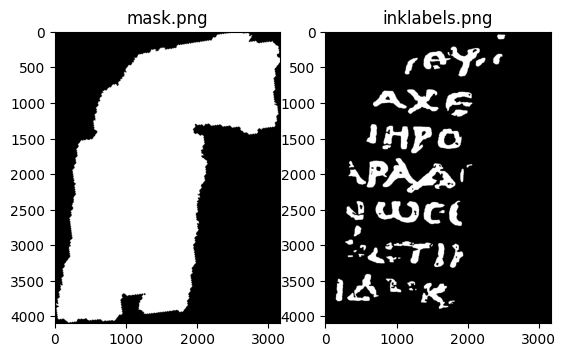

In [22]:
# resize image to fixed height
def resize(img):
    current_width, current_height = img.size
    aspect_ratio = current_width / current_height
    new_width = int(FIXED_HEIGHT * aspect_ratio)
    new_size = (new_width, FIXED_HEIGHT)
    img = img.resize(new_size)
    return img

def load_mask(dir_1, dir_2):
    mask_img = Image.open(f"{DATA_DIR}{dir_1}/{dir_2}/mask.png").convert("1")
    mask_img = resize(mask_img)
    return torch.tensor(np.array(mask_img), dtype=torch.bool)


def load_labels(dir_1, dir_2):
    label_img = Image.open(f"{DATA_DIR}{dir_1}/{dir_2}/inklabels.png")
    label_img = np.array(resize(label_img))
    return torch.from_numpy(label_img).gt(0)

mask = load_mask("train", "1")
labels = load_labels("train", "1")

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()



In [23]:

# Check the shapes of the masks and labels
mask_test_a = load_mask("test", "a")
mask_test_b = load_mask("test", "b")

mask_train_1 = load_mask("train", 1)
labels_train_1 = load_labels("train", 1)

mask_train_2 = load_mask("train", 2)
labels_train_2 = load_labels("train", 2)

mask_train_3 = load_mask("train", 3)
labels_train_3 = load_labels("train", 3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")



mask_test_a: torch.Size([4096, 9507])
mask_test_b: torch.Size([4096, 4753])
-
mask_train_1: torch.Size([4096, 3169])
labels_train_1: torch.Size([4096, 3169])
-
mask_train_2: torch.Size([4096, 2625])
labels_train_2: torch.Size([4096, 2625])
-
mask_train_3: torch.Size([4096, 2826])
labels_train_3: torch.Size([4096, 2826])


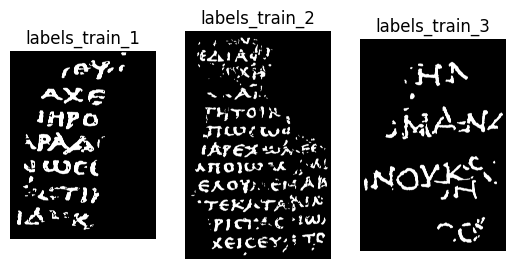

In [24]:
label_image_set = [labels_train_1, labels_train_2, labels_train_3]
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.imshow(label_image_set[i - 1], cmap='gray')
    plt.title(f"labels_train_{i}")
    plt.axis('off')
plt.show()

In [25]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    z_slices_fnames = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = Image.open(filename)
        img = np.array(resize(img), dtype="float32")
        z_slice = torch.from_numpy(img)
        z_slices.append(z_slice)
        
    return torch.stack(z_slices, dim=0)

In [26]:

# Check the shapes of the masks and labels
mask_test_a = load_mask("test", "a")
mask_test_b = load_mask("test", "b")

mask_train_1 = load_mask("train", 1)
labels_train_1 = load_labels("train", 1)

mask_train_2 = load_mask("train", 2)
labels_train_2 = load_labels("train", 2)

mask_train_3 = load_mask("train", 3)
labels_train_3 = load_labels("train", 3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")


mask_test_a: torch.Size([4096, 9507])
mask_test_b: torch.Size([4096, 4753])
-
mask_train_1: torch.Size([4096, 3169])
labels_train_1: torch.Size([4096, 3169])
-
mask_train_2: torch.Size([4096, 2625])
labels_train_2: torch.Size([4096, 2625])
-
mask_train_3: torch.Size([4096, 2826])
labels_train_3: torch.Size([4096, 2826])


In [27]:
volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")

volume_train_2 = load_volume(split="train", index=2)
print(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")

volume_train_3 = load_volume(split="train", index=3)
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

volume = torch.cat([volume_train_1, volume_train_2, volume_train_3], dim=2)
print(f"total volume: {volume.shape}")

del volume_train_1, volume_train_2, volume_train_3

16it [00:02,  7.09it/s]


volume_train_1: torch.Size([16, 4096, 3169]), torch.float32


16it [00:02,  7.46it/s]


volume_train_2: torch.Size([16, 4096, 2625]), torch.float32


16it [00:01,  8.43it/s]


volume_train_3: torch.Size([16, 4096, 2826]), torch.float32
total volume: torch.Size([16, 4096, 8620])


In [28]:
labels = torch.cat([labels_train_1, labels_train_2, labels_train_3], dim=1)
print(f"labels: {labels.shape}, {labels.dtype}")

mask = torch.cat([mask_train_1, mask_train_2, mask_train_3], dim=1)
print(f"mask: {mask.shape}, {mask.dtype}")

labels: torch.Size([4096, 8620]), torch.bool
mask: torch.Size([4096, 8620]), torch.bool


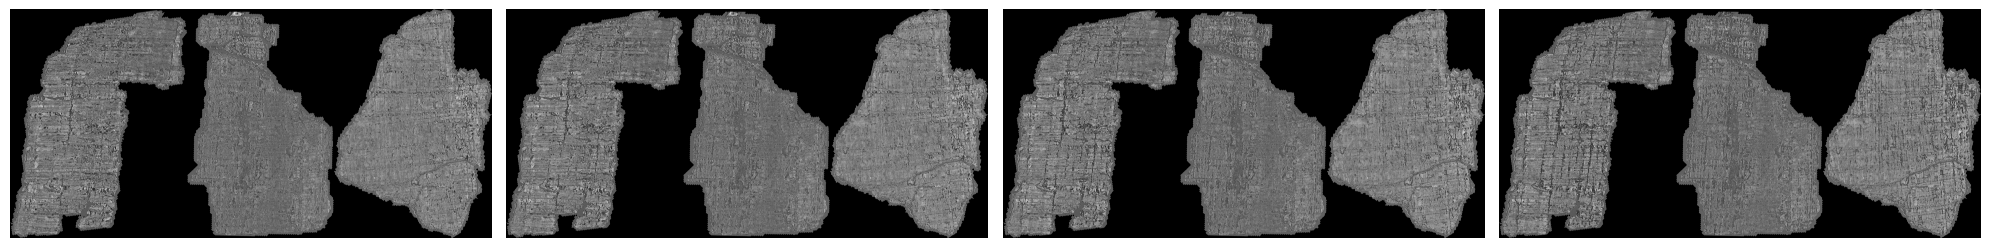

In [29]:
for i in range(1, 5):
    plt.subplot(1, 4, i)
    plt.imshow(volume[i, :, :], cmap='gray')
    plt.gcf().set_size_inches(20, 10)
    plt.axis('off')
plt.tight_layout()
plt.show()

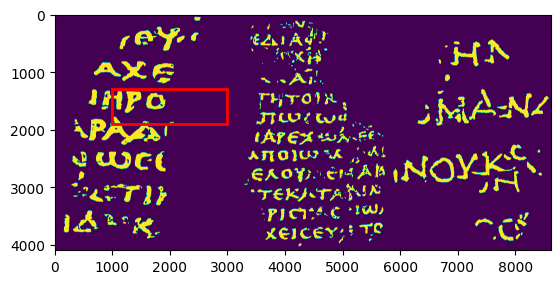

In [30]:
val_location = (1300, 1000)
val_size = (600, 2000)
fig, ax = plt.subplots()
ax.imshow(labels.cpu())
patch = patches.Rectangle((val_location[1], val_location[0]), val_size[1], val_size[0], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

In [31]:
def sample_random_location(shape):
    random_train_x = torch.randint(low=BUFFER, high=shape[0] - BUFFER - 1, size=(1,))
    random_train_y = torch.randint(low=BUFFER, high=shape[1] - BUFFER - 1, size=(1,))
    random_train_location = torch.cat([random_train_x, random_train_y])
    return random_train_location

def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]]

sample_random_location_train = lambda x: sample_random_location(mask.shape)
is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

def is_in_val_zone(location, val_location, val_zone_size):
    x = location[0]
    y = location[1]
    x_match = val_location[0] - BUFFER <= x <= val_location[0] + val_zone_size[0] + BUFFER
    y_match = val_location[1] - BUFFER <= y <= val_location[1] + val_zone_size[1] + BUFFER
    return x_match and y_match

def is_proper_train_location(location):
    return not is_in_val_zone(location, val_location, val_size) and is_in_mask_train(location)
    

In [32]:

from torch.utils.data import Dataset

class LocationDataset(Dataset):
    def __init__(self, mask, val_location, val_zone_size, BUFFER):
        self.mask = mask
        self.val_location = val_location
        self.val_zone_size = val_zone_size
        self.BUFFER = BUFFER

    def __len__(self):
        # Return the number of samples you want to generate
        return 1280

    def __getitem__(self, index):
        # Generate a random location
        loc = self.sample_random_location(self.mask.shape)
        while not self.is_proper_train_location(loc):
            loc = self.sample_random_location(self.mask.shape)
        return loc

    def sample_random_location(self, shape):
        random_train_x = torch.randint(low=self.BUFFER, high=shape[0] - self.BUFFER - 1, size=(1,))
        random_train_y = torch.randint(low=self.BUFFER, high=shape[1] - self.BUFFER - 1, size=(1,))
        random_train_location = torch.cat([random_train_x, random_train_y])
        return random_train_location

    def is_in_masked_zone(self, location):
        return self.mask[location[0].item(), location[1].item()]

    def is_in_val_zone(self, location):
        x = location[0].item()
        y = location[1].item()
        x_match = self.val_location[0] - self.BUFFER <= x <= self.val_location[0] + self.val_zone_size[0] + self.BUFFER
        y_match = self.val_location[1] - self.BUFFER <= y <= self.val_location[1] + self.val_zone_size[1] + self.BUFFER
        return x_match and y_match

    def is_proper_train_location(self, location):
        return not self.is_in_val_zone(location) and self.is_in_masked_zone(location)

dataset = LocationDataset(mask, val_location, val_size, BUFFER)



In [33]:
train_locations_ds = LocationDataset(mask, val_location, val_size, BUFFER)
train_locations_loader = data.DataLoader(train_locations_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [34]:
len(train_locations_ds)

1280

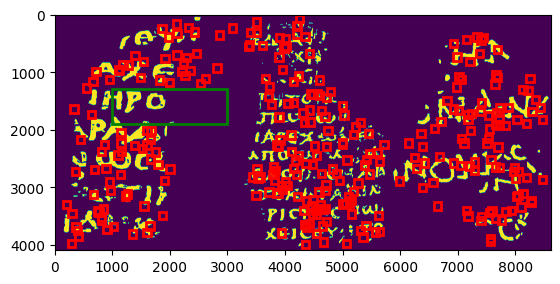

In [35]:
fig, ax = plt.subplots()
ax.imshow(labels)

for i,(x, y) in enumerate(train_locations_ds):
    if i > 300:
        break
    
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

val_patch = patches.Rectangle([val_location[1], val_location[0]], val_size[1], val_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(val_patch)
plt.show()

In [36]:
from torch.utils.data import Dataset

def extract_subvolume(location, volume):
    x = location[0]
    y = location[1]
    subvolume = volume[:,x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER]
    subvolume = subvolume.to(torch.float32) / 65535.
    return subvolume

def extract_labels(location, labels):
    x = location[0]
    y = location[1]
    label = labels[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER]
    a = label.unsqueeze(dim=0)
    return a

def extract_subvolume_and_label(location):
    subvolume = extract_subvolume(location, volume)
    label = extract_labels(location, labels)
    return subvolume, label

class CustomDataset(Dataset):
    def __init__(self, train_locations_ds, volume, labels):
        self.train_locations_ds = train_locations_ds
        self.volume = volume
        self.labels = labels
        self.n = 0

    def __len__(self):
        return len(self.train_locations_ds)
 

    def __getitem__(self, index):
        location = self.train_locations_ds[index]
        subvolume = extract_subvolume(location, volume)
        label = extract_labels(location, labels)

        return subvolume, label

In [37]:
train_ds = CustomDataset(train_locations_ds, volume, labels)
train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [38]:
import time
t0 = time.time()
n = 200
for _ in enumerate(train_loader):
    pass
print(f"Time per batch: {(time.time() - t0) / n:.4f}s")

Time per batch: 0.0053s


In [39]:
val_locations_stride = BUFFER
val_locations = []
for x in range(val_location[0], val_location[0] + val_size[0], val_locations_stride):
    for y in range(val_location[1], val_location[1] + val_size[1], val_locations_stride):
        val_locations.append((x, y))

class ValidationDataset(Dataset):
    def __init__(self, val_locations, mask, val_zone_size):
        self.val_locations = val_locations
        self.mask = mask
        self.val_zone_size = val_zone_size

    def __len__(self):
        return len(self.val_locations)

    def __getitem__(self, index):
        location = self.val_locations[index]
        subvolume = extract_subvolume(location, volume)  # Implement the extract_subvolume function
        label = extract_labels(location, labels)  # Implement the extract_labels function
        return subvolume, label

In [40]:
val_dataset = ValidationDataset(val_locations, mask, val_size)
val_loader = data.DataLoader(val_dataset,  batch_size = BATCH_SIZE, shuffle=True)

In [41]:
for subvolume, label in val_loader:
    print(f"subvolume: {subvolume.shape}, {subvolume.dtype}")
    print(f"label: {label.shape}, {label.dtype}")
    break

subvolume: torch.Size([32, 16, 128, 128]), torch.float32
label: torch.Size([32, 1, 128, 128]), torch.bool


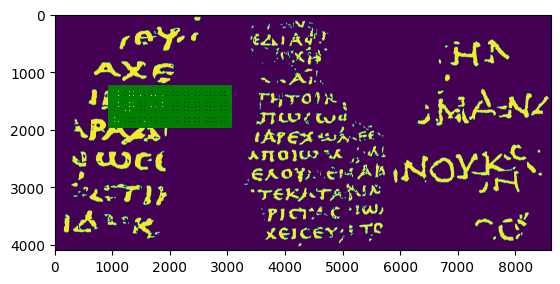

In [42]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in val_locations:
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(patch)
plt.show()

In [43]:
def trivial_baseline(dataset):
    total = 0
    matches = 0.
    for _, batch_label in tqdm(dataset):
        # Assuming the batch_label is of shape [batch_size, 64, 64, 1]
        batch_label = batch_label.squeeze(0)  # Remove the first dimension (batch size)
        matches += torch.sum(batch_label)
        total += torch.prod(torch.tensor(batch_label.shape))

    return 1. - matches / total

score = trivial_baseline(val_loader).item()
print(f"Best validation score achievable trivially: {score * 100:.2f}% accuracy")

100%|██████████| 10/10 [00:00<00:00, 45.12it/s]

Best validation score achievable trivially: 87.50% accuracy


In [44]:
class ChannelAttentionModule(nn.Module):
    def __init__(self, channel, ratio=16):
        super(ChannelAttentionModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.shared_MLP = nn.Sequential(
            nn.Conv2d(channel, channel // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channel // ratio, channel, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avgout = self.shared_MLP(self.avg_pool(x))
        maxout = self.shared_MLP(self.max_pool(x))
        return self.sigmoid(avgout + maxout)

class SpatialAttentionModule(nn.Module):
    def __init__(self):
        super(SpatialAttentionModule, self).__init__()
        self.conv2d = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=7, stride=1, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avgout = torch.mean(x, dim=1, keepdim=True)
        maxout, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avgout, maxout], dim=1)
        out = self.sigmoid(self.conv2d(out))
        return out

class CBAM(nn.Module):
    def __init__(self, channel):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttentionModule(channel)
        self.spatial_attention = SpatialAttentionModule()

    def forward(self, x):
        out = self.channel_attention(x) * x
        out = self.spatial_attention(out) * out
        return out



In [45]:
import torch
import torch.nn as nn


class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        # number of input channels is a number of filters in the previous layer
        # number of output channels is a number of filters in the current layer
        # "same" convolutions
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out


class AttentionUNet(nn.Module):

    def __init__(self, img_ch=16, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """
        e : encoder layers
        d : decoder layers
        s : skip-connections from encoder layers to decoder layers
        """
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1) # concatenate attention-weighted skip connection with previous layer output
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return out

In [2]:
import torch
import torch.nn as nn


class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        # number of input channels is a number of filters in the previous layer
        # number of output channels is a number of filters in the current layer
        # "same" convolutions
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out


class AttentionUNet(nn.Module):

    def __init__(self, img_ch=16, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """
        e : encoder layers
        d : decoder layers
        s : skip-connections from encoder layers to decoder layers
        """
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1) # concatenate attention-weighted skip connection with previous layer output
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return out

In [46]:
class AverageMeter(object):
    def __init__(self):
        self.sum = 0
        self.n = 0

    def update(self, x, n=1):
        self.sum += float(x)
        self.n += n

    def reset(self):
        self.sum = 0
        self.n = 0

    def get_value(self):
        if self.n:
            return self.sum / self.n
        return 0

In [18]:
print("=====> Begin training")
meter = AverageMeter()
net = UNet(in_ch=Z_DIM, out_classes=1, up_sample_mode='conv_transpose').to(DEVICE)
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
best_val_loss = 100
best_val_acc = 0
net.train()
for epoch in range(30):
    bar = tqdm(enumerate(train_loader), total = 1280 / BATCH_SIZE)
    bar.set_description_str(f"Epoch: {epoch}")
    for i, (train_subvolume, train_label) in bar:
        subvolume = train_subvolume.to(DEVICE)
        label = train_label.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(subvolume)
        loss = criterion(outputs, label.float())
        loss.backward()
        optimizer.step()
        meter.update(loss)
        bar.set_postfix_str(f"Avg loss: {np.round(meter.get_value(),3)}")

    meter_loss =AverageMeter()
    meter_acc = AverageMeter()
    net.eval()
    val_loss = 0
    val_acc = 0
    for _, (val_subvolume, val_label) in enumerate(val_loader):
        val_subvolume = val_subvolume.to(DEVICE)
        val_label = val_label.to(DEVICE)
        val_outputs = net(val_subvolume)
        loss = criterion(val_outputs, val_label.float())
        meter_loss.update(loss)
        pred = torch.sigmoid(val_outputs) > 0.5
        meter_acc.update((pred == val_label.to(DEVICE)).sum(), int(torch.prod(torch.tensor(val_label.shape))))
        net.train()
    val_loss = np.round(meter_loss.get_value(),3)
    val_acc = np.round(meter_acc.get_value(),3)

        
    print(f"======> Val Loss:{val_loss} | Val Acc:{val_acc} ")
    if epoch == 19:
        torch.save(net.state_dict(), "/root/autodl-tmp/COMP9417GroupProject/param/AttentionUNet_Best.pt")
        print("======> Save best val model")
    


=====> Begin training


Epoch: 0: 100%|██████████| 20/20.0 [00:45<00:00,  2.25s/it, Avg loss: 0.666]


======> Val Loss:0.61 | Val Acc:0.814 
======> Save best val model


Epoch: 1: 100%|██████████| 20/20.0 [00:18<00:00,  1.07it/s, Avg loss: 0.614]


======> Val Loss:0.512 | Val Acc:0.814 
======> Save best val model


Epoch: 2: 100%|██████████| 20/20.0 [00:18<00:00,  1.08it/s, Avg loss: 0.585]


======> Val Loss:0.511 | Val Acc:0.814 


Epoch: 3: 100%|██████████| 20/20.0 [00:18<00:00,  1.07it/s, Avg loss: 0.566]


======> Val Loss:0.507 | Val Acc:0.813 


Epoch: 4: 100%|██████████| 20/20.0 [00:18<00:00,  1.07it/s, Avg loss: 0.551]


======> Val Loss:0.505 | Val Acc:0.804 


Epoch: 5: 100%|██████████| 20/20.0 [00:18<00:00,  1.06it/s, Avg loss: 0.539]


======> Val Loss:2.095 | Val Acc:0.54 


Epoch: 6: 100%|██████████| 20/20.0 [00:18<00:00,  1.07it/s, Avg loss: 0.531]


======> Val Loss:0.538 | Val Acc:0.749 


Epoch: 7: 100%|██████████| 20/20.0 [00:18<00:00,  1.06it/s, Avg loss: 0.523]


======> Val Loss:0.711 | Val Acc:0.466 


Epoch: 8: 100%|██████████| 20/20.0 [00:19<00:00,  1.05it/s, Avg loss: 0.515]


======> Val Loss:0.529 | Val Acc:0.752 


Epoch: 9: 100%|██████████| 20/20.0 [00:19<00:00,  1.05it/s, Avg loss: 0.508]


======> Val Loss:0.707 | Val Acc:0.593 


Epoch: 10: 100%|██████████| 20/20.0 [00:19<00:00,  1.05it/s, Avg loss: 0.502]


======> Val Loss:0.46 | Val Acc:0.825 
======> Save best val model


Epoch: 11: 100%|██████████| 20/20.0 [00:18<00:00,  1.06it/s, Avg loss: 0.496]


======> Val Loss:0.52 | Val Acc:0.743 


Epoch: 12: 100%|██████████| 20/20.0 [00:18<00:00,  1.06it/s, Avg loss: 0.489]


======> Val Loss:0.667 | Val Acc:0.657 


Epoch: 13: 100%|██████████| 20/20.0 [00:18<00:00,  1.06it/s, Avg loss: 0.482]


======> Val Loss:0.911 | Val Acc:0.491 


Epoch: 14: 100%|██████████| 20/20.0 [00:18<00:00,  1.06it/s, Avg loss: 0.477]


======> Val Loss:0.454 | Val Acc:0.823 


Epoch: 15: 100%|██████████| 20/20.0 [00:18<00:00,  1.07it/s, Avg loss: 0.471]


======> Val Loss:0.458 | Val Acc:0.816 


Epoch: 16: 100%|██████████| 20/20.0 [00:18<00:00,  1.07it/s, Avg loss: 0.467]


======> Val Loss:2.669 | Val Acc:0.33 


Epoch: 17: 100%|██████████| 20/20.0 [00:18<00:00,  1.06it/s, Avg loss: 0.463]


======> Val Loss:0.434 | Val Acc:0.82 


Epoch: 18: 100%|██████████| 20/20.0 [00:18<00:00,  1.07it/s, Avg loss: 0.459]


======> Val Loss:1.156 | Val Acc:0.477 


Epoch: 19: 100%|██████████| 20/20.0 [00:18<00:00,  1.06it/s, Avg loss: 0.454]


======> Val Loss:0.425 | Val Acc:0.831 
======> Save best val model


Epoch: 20: 100%|██████████| 20/20.0 [00:18<00:00,  1.07it/s, Avg loss: 0.45] 


======> Val Loss:0.439 | Val Acc:0.816 


Epoch: 21: 100%|██████████| 20/20.0 [00:18<00:00,  1.06it/s, Avg loss: 0.446]


======> Val Loss:0.425 | Val Acc:0.817 


Epoch: 22: 100%|██████████| 20/20.0 [00:18<00:00,  1.07it/s, Avg loss: 0.443]


======> Val Loss:0.465 | Val Acc:0.798 


Epoch: 23: 100%|██████████| 20/20.0 [00:18<00:00,  1.06it/s, Avg loss: 0.439]


======> Val Loss:0.433 | Val Acc:0.829 


Epoch: 24: 100%|██████████| 20/20.0 [00:18<00:00,  1.07it/s, Avg loss: 0.435]


======> Val Loss:0.445 | Val Acc:0.808 


Epoch: 25: 100%|██████████| 20/20.0 [00:18<00:00,  1.06it/s, Avg loss: 0.432]


======> Val Loss:0.454 | Val Acc:0.829 


Epoch: 26: 100%|██████████| 20/20.0 [00:18<00:00,  1.07it/s, Avg loss: 0.428]


======> Val Loss:2.22 | Val Acc:0.436 


Epoch: 27: 100%|██████████| 20/20.0 [00:18<00:00,  1.05it/s, Avg loss: 0.425]


======> Val Loss:0.417 | Val Acc:0.837 
======> Save best val model


Epoch: 28: 100%|██████████| 20/20.0 [00:18<00:00,  1.07it/s, Avg loss: 0.422]


======> Val Loss:0.437 | Val Acc:0.823 


Epoch: 29: 100%|██████████| 20/20.0 [00:18<00:00,  1.06it/s, Avg loss: 0.419]


======> Val Loss:0.446 | Val Acc:0.828 


In [7]:
# Load the best model
criterion = nn.BCEWithLogitsLoss(reduction='mean')
net.load_state_dict(torch.load("/root/autodl-tmp/COMP9417GroupProject/param/AttentionUNet_best.pth"))
net.criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
meter_loss =AverageMeter()
meter_acc = AverageMeter()
net.eval()
val_loss = 0
val_acc = 0
for _, (val_subvolume, val_label) in enumerate(val_loader):
    val_subvolume = val_subvolume.to(DEVICE)
    val_label = val_label.to(DEVICE)
    val_outputs = net(val_subvolume)
    loss = criterion(val_outputs, val_label.float())
    meter_loss.update(loss)
    pred = torch.sigmoid(val_outputs) > 0.5
    meter_acc.update((pred == val_label.to(DEVICE)).sum(), int(torch.prod(torch.tensor(val_label.shape))))
    net.train()
val_loss = np.round(meter_loss.get_value(),3)
val_acc = np.round(meter_acc.get_value(),3)

net.eval()
print(f"Val loss: {val_loss} | Val acc: {val_acc}")

Val loss: 0.417 | Val acc: 0.837


In [8]:
from tqdm import tqdm
def compute_predictions_map(split, index):
    print(f"======> Load data for {split}/{index}")
    test_volume = load_volume(split=split, index=index)
    test_mask = load_mask(split=split, index=index)
    print(f"======> Volume shape: {test_volume.shape}")
    test_locations = []
    stride = BUFFER // 2

    for x in range(BUFFER, test_volume.shape[1] - BUFFER, stride):
        for y in range(BUFFER, test_volume.shape[2] - BUFFER, stride):
            if is_in_masked_zone([torch.tensor(x),torch.tensor(y)], test_mask):
                test_locations.append((x, y))
    print(f"======> {len(test_locations)} test locations (after filtering by mask)")

    predictions_map = torch.zeros((1, 1, test_volume.shape[1], test_volume.shape[2]))
    predictions_map_counts = torch.zeros((1, 1, test_volume.shape[1], test_volume.shape[2]))
    print(f"======> Compute predictions")

    with torch.no_grad():
        bar = tqdm(test_locations)
        for loc in bar:
            subvolume, label = get_subvolume([loc], test_volume, None)
            outputs = net(subvolume.to(DEVICE))
            pred = torch.sigmoid(outputs)
            # print(loc, (pred > 0.5).sum())
            # Here a single location may be with multiple result
            predictions_map[:, :, loc[0] - BUFFER : loc[0] + BUFFER, loc[1] - BUFFER : loc[1] + BUFFER] += pred.cpu()
            predictions_map_counts[:, :, loc[0] - BUFFER : loc[0] + BUFFER, loc[1] - BUFFER : loc[1] + BUFFER] += 1
    # print(predictions_map_b[:,:, 2500, 1000])
    # print(predictions_map_counts[:,:, 2500, 1000])
    predictions_map /= (predictions_map_counts + 1e-7)
    return predictions_map

In [21]:
predictions_map_a = compute_predictions_map(split="test", index="a")
predictions_map_b = compute_predictions_map(split="test", index="b")

======> Load data for test/a


16it [00:06,  2.43it/s]


======> Volume shape: torch.Size([16, 4096, 9507])
======> 23391 test locations (after filtering by mask)
======> Compute predictions


100%|██████████| 23391/23391 [03:24<00:00, 114.34it/s]


======> Load data for test/b


16it [00:03,  4.95it/s]


======> Volume shape: torch.Size([16, 4096, 4753])
======> 9951 test locations (after filtering by mask)
======> Compute predictions


100%|██████████| 9951/9951 [01:27<00:00, 113.93it/s]


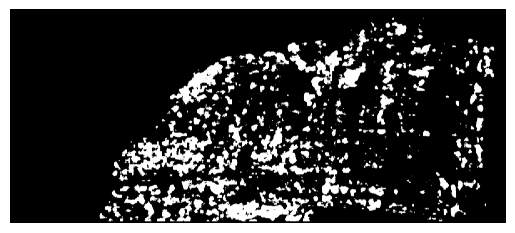

In [74]:
import matplotlib.pyplot as plt
# Threshold is very important !!!!!
plt.imshow(predictions_map_a.squeeze() > 0.15, cmap='gray')
plt.axis("off")
plt.savefig("AttentionUNet_predictions_map_a.png")

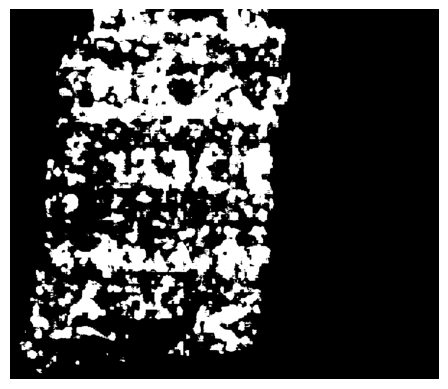

In [75]:
plt.imshow(predictions_map_b.squeeze() > 0.15, cmap='gray')
plt.axis("off")
plt.savefig("AttentionUnet_predictions_map_b.png")

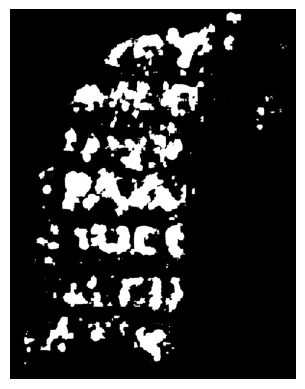

In [50]:
plt.imshow(pred.squeeze() > 0.2, cmap='gray')
plt.axis("off")
plt.savefig("Unet_predictions_map_1.png")

In [71]:
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return c_recall, c_precision, dice

In [72]:
targets = np.array(resize(Image.open("Data/train/1/inklabels.png")))
reshaped_pred = pred.squeeze()
c_recall, c_precision, dice = fbeta_score(reshaped_pred, targets, 0.2)
print(f"c_recall: {c_recall}")
print(f"c_precision: {c_precision}")
print(f"fbeta_score: {dice}")

c_recall: 0.7890037298202515
c_precision: 0.6057001352310181
fbeta_score: 0.6352083683013916
